### Script

In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
from utils import ImageDataset, SaveFeatures, imshow_transform
from custom_model import model_4D
from torch.autograd import Variable
from skimage.transform import resize
from skimage.io import imshow
import wandb
import torch.optim.lr_scheduler as lr_scheduler

%matplotlib inline

In [2]:
current_computer =  "ubuntu" # "macbook" 
im_size = 200


if current_computer == "ubuntu":
    hs_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/hs'
    RGB_dir = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/rgb'
    labels_file = f'/home/nadjaflechner/Palsa_data/cropped_hillshade_{im_size}m/palsa_labels.csv'
elif current_computer == "macbook":
    hs_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/hs'
    RGB_dir = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/rgb'
    labels_file = '/Users/nadja/Documents/UU/Thesis/Data/cropped_hillshade/palsa_labels.csv'

labels_df = pd.read_csv(labels_file, index_col=0)
testing_dataset =  ImageDataset(hs_dir, RGB_dir, labels_df, im_size)
test_loader = DataLoader(testing_dataset, batch_size=1, shuffle=True, num_workers=1)


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

run = wandb.init(project= 'VGG_CAMs', id= '3493djxg', resume = 'must')
artifact = run.use_artifact('nadjaflechner/VGG_CAMs/model:v31', type='model')
artifact_dir = artifact.download()
state_dict = torch.load(f"{artifact_dir}/model.pth")
model = model_4D()
model.load_state_dict(state_dict)
model.to(device)
model.eval()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nadja-flechner (nadjaflechner). Use `wandb login --relogin` to force relogin


wandb:   1 of 1 files downloaded.  


model_4D(
  (features): Sequential(
    (0): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(

In [50]:
# Grab an image label pair to 
im, lab = next(iter(test_loader))

In [87]:
#######
# For loading hand picked images: 

with rasterio.open('/home/nadjaflechner/Palsa_data/cropped_hillshade_200m/rgb/760_71_5050_2018_crop_10.tif') as RGB_src:
    # Read the image data
    RGB_img = RGB_src.read()

with rasterio.open('/home/nadjaflechner/Palsa_data/cropped_hillshade_200m/hs/760_71_5050_2018_crop_10_hs.tif') as hs_src:
    # Read the image data
    hs_img = hs_src.read()

# convert and upsample hs image
hs_image_array = np.array(hs_img)
hs_image_tensor = torch.from_numpy(hs_image_array)
hs_image_tensor = hs_image_tensor.float()
bilinear = nn.Upsample(size=im_size*2, mode='bilinear')
hs_upsampled_tensor = bilinear(hs_image_tensor.unsqueeze(0)).squeeze(0) 

# converting RGB to tensor
RGB_image_array = np.array(RGB_img)
RGB_image_tensor = torch.from_numpy(RGB_image_array)
RGB_image_tensor = RGB_image_tensor.float()

combined_tensor = torch.concatenate((RGB_image_tensor, hs_upsampled_tensor))

im = combined_tensor.unsqueeze(0)


In [89]:
from skimage.segmentation import mark_boundaries, find_boundaries
from pysnic.algorithms.snic import snic

def create_superpixel_mask(superpixels, binary_mask, threshold=0.5):
    # Get the unique superpixel labels
    unique_labels = np.unique(superpixels)

    # Create a dictionary to store the overlap percentage for each superpixel
    overlap_dict = {}

    # Iterate over each superpixel
    for label in unique_labels:
        # Create a mask for the current superpixel
        superpixel_mask = (superpixels == label)

        # Count the number of pixels in the superpixel
        superpixel_size = np.sum(superpixel_mask)

        # Count the number of pixels in the superpixel that overlap with the binary mask
        overlap_count = np.sum(superpixel_mask & binary_mask)

        # Calculate the overlap percentage
        overlap_percentage = overlap_count / superpixel_size

        # Store the overlap percentage in the dictionary
        overlap_dict[label] = overlap_percentage

    # Create a new binary mask based on the overlap threshold
    new_binary_mask = np.zeros_like(binary_mask, dtype=bool)

    # Iterate over each superpixel again
    for label in unique_labels:
        # Check if the overlap percentage is greater than the threshold
        if overlap_dict[label] > threshold:
            # Set the pixels belonging to the superpixel to 1 in the new binary mask
            new_binary_mask[superpixels == label] = 1

    return new_binary_mask

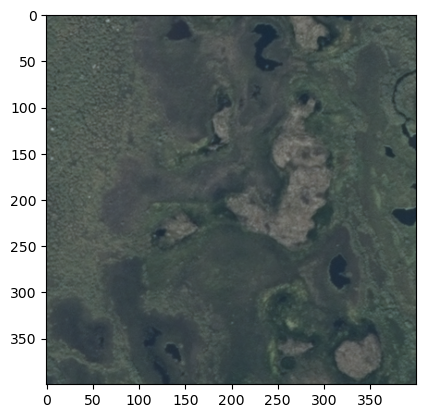

In [91]:
plt.imshow(cpu_img[:,:,:3])

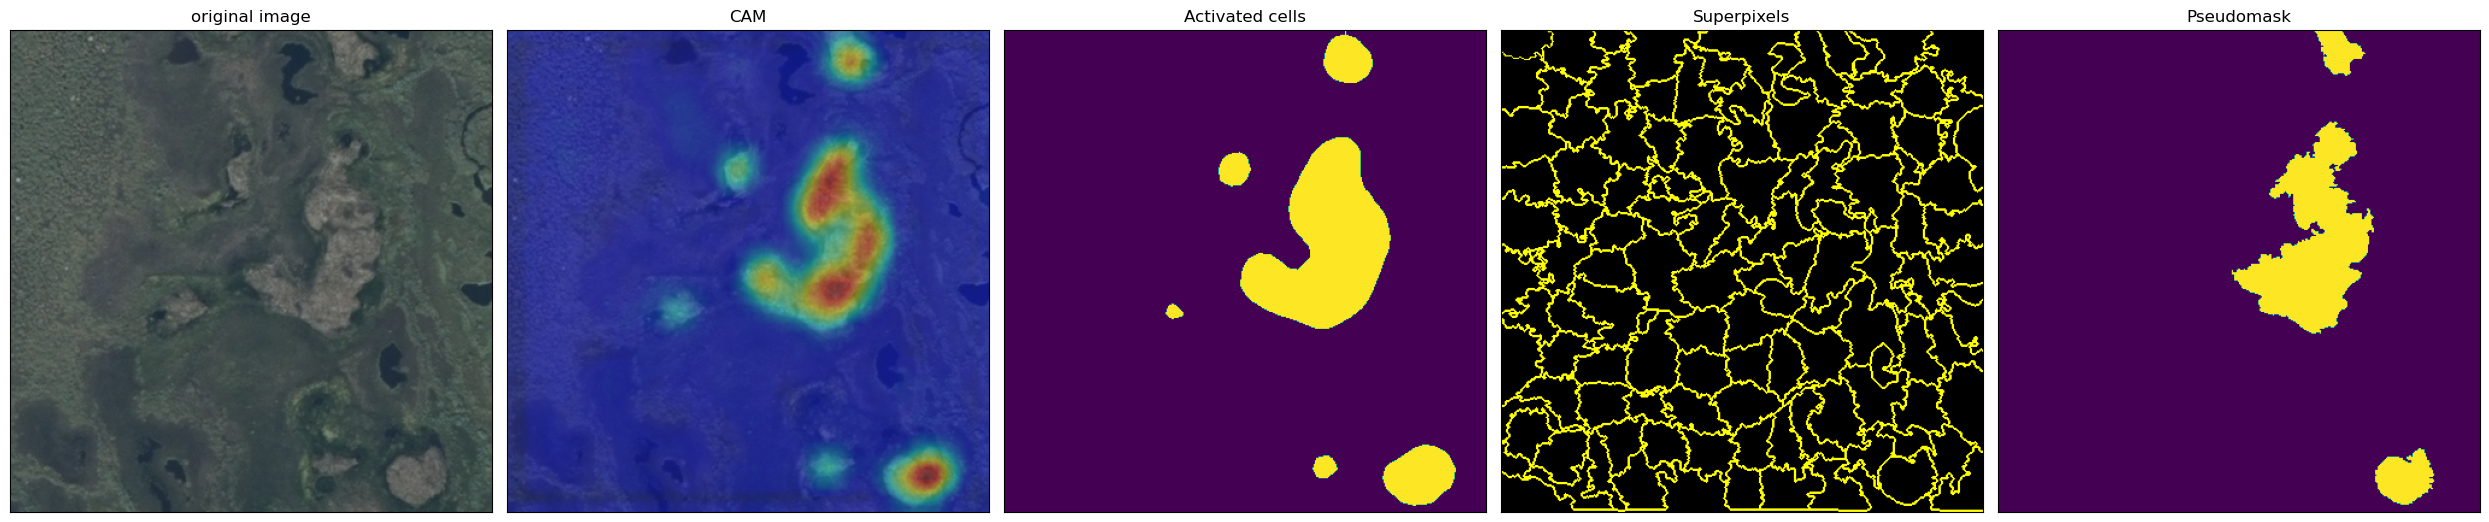

In [105]:

#get the last convolution
sf = SaveFeatures(model.features[-4])
model.eval()

im = Variable(im).to(device)
outputs = model(im).to(device)

# generate CAM
sf.remove()
arr = sf.features.cpu().detach()#.numpy()

pals_acts = torch.nn.functional.interpolate(
                                    arr[:,1,:,:].unsqueeze(1), 
                                    scale_factor = im.shape[3]/arr.shape[3], 
                                    mode='bilinear').cpu().detach()
activation_threshold = pals_acts.mean() + torch.std(pals_acts)
pixels_activated = torch.where(torch.Tensor(pals_acts) > activation_threshold.cpu(), 1, 0).squeeze(0).permute(1,2,0).numpy()

# Plot image with CAM
cpu_img = im.squeeze().cpu().detach().permute(1,2,0).long().numpy()
superpixels = np.array(snic(cpu_img, 100, 10)[0])
pseudomask = create_superpixel_mask(superpixels, pixels_activated.squeeze())

############
# Plotting #
############

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (25,6))

ax1.imshow(cpu_img[:,:,:3])
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(f'original image')

ax2.imshow(cpu_img[:,:,:3])
ax2.imshow(pals_acts.view(im.shape[3], im.shape[3], 1), alpha=.4, cmap='jet')
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('CAM')

ax3.imshow(pixels_activated)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('Activated cells')

ax4.imshow(mark_boundaries(cpu_img[:,:,:3], superpixels)) # TODO change so image is actually plotted.
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('Superpixels')

ax5.imshow(pseudomask)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title('Pseudomask')

plt.tight_layout()
